In [7]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from io import BytesIO
from PIL import Image, ImageOps

from train import TrainConfig
train_config = TrainConfig()

IMAGE_DIR = Path("sample_data")
CHECKPOINT_PATH = Path("checkpoints/epoch_002.pt")
THRESHOLD = 0.2

print('Resolved device:', train_config.resolved_device())
print('Target size:', train_config.target_size)

Resolved device: cpu
Target size: 320


In [8]:
from model.hybrid_forgery_detector import HybridForgeryConfig, HybridForgeryDetector

def _predict_image_array(image_arr: np.ndarray, checkpoint_path: Path, threshold: float) -> np.ndarray:
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    cfg = HybridForgeryConfig(**checkpoint['config']['model_config'])
    device = train_config.resolved_device()
    model = HybridForgeryDetector(cfg).to(device)
    model.load_state_dict(checkpoint['model_state'])
    model.eval()
    tensor = torch.from_numpy(image_arr.transpose(2, 0, 1)).unsqueeze(0).to(device)
    zero_noise = torch.zeros(1, 3, tensor.shape[-2], tensor.shape[-1], device=device)
    noise_inputs = {'residual': zero_noise}
    with torch.no_grad():
        mask = model.predict_mask(tensor, threshold=threshold, noise_features=noise_inputs)
    return mask.squeeze().cpu().numpy()

def _load_images_from_dir(image_dir: Path, exts=(".jpg", ".jpeg", ".png", ".bmp")) -> list[tuple[Image.Image, str]]:
    image_dir = Path(image_dir)
    if not image_dir.exists():
        raise FileNotFoundError(f"Image directory not found: {image_dir}")
    images = []
    for p in sorted(image_dir.iterdir()):
        if p.is_file() and p.suffix.lower() in exts:
            try:
                images.append((Image.open(p).convert("RGB"), p.name))
            except Exception as e:
                print(f"Warning: failed to open {p}: {e}")
    return images

C:\Users\Maranan\AppData\Local\Temp\ipykernel_9532\3262400628.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location="cpu"

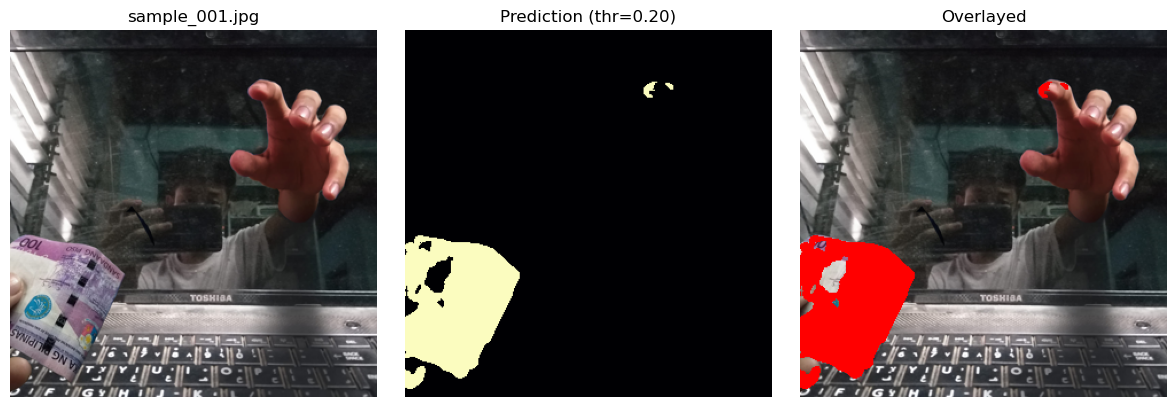

In [ ]:
images = _load_images_from_dir(IMAGE_DIR)

if not images:
    print(f"No images found in {IMAGE_DIR}")
else:
    try:
        resample_mode = Image.Resampling.BICUBIC
    except AttributeError:
        resample_mode = Image.BICUBIC

    target_hw = (train_config.target_size, train_config.target_size)
    checkpoint_for_single = Path(CHECKPOINT_PATH)
    if not checkpoint_for_single.exists():
        print(f'Warning: checkpoint not found: {checkpoint_for_single}. You may need to set CHECKPOINT_PATH.')

    for uploaded_image, uploaded_label in images:
        resized_image = ImageOps.fit(uploaded_image, target_hw, method=resample_mode)
        normalized = np.array(resized_image, dtype=np.float32) / 255.0

        pred_mask = _predict_image_array(normalized, checkpoint_for_single, THRESHOLD)

        mask_uint8 = (pred_mask * 255).astype(np.uint8)
        mask_img = Image.fromarray(mask_uint8).resize(resized_image.size, resample=Image.BICUBIC)
        mask_rgba = Image.new("RGBA", resized_image.size)
        mask_rgba.paste((255, 0, 0, 128), (0, 0, resized_image.size[0], resized_image.size[1]))
        mask_rgba.putalpha(mask_img)
        resized_rgba = resized_image.convert("RGBA")
        overlayed_image = Image.alpha_composite(resized_rgba, mask_rgba)

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(resized_image)
        axes[0].set_title(uploaded_label)
        axes[0].axis('off')
        axes[1].imshow(pred_mask, cmap='magma')
        axes[1].set_title(f'Prediction (thr={THRESHOLD:.2f})')
        axes[1].axis('off')
        axes[2].imshow(overlayed_image)
        axes[2].set_title('Overlayed')
        axes[2].axis('off')
        plt.tight_layout()
        plt.show()

In [ ]:
import time
from pathlib import Path
import torch
from model.hybrid_forgery_detector import HybridForgeryConfig, HybridForgeryDetector

checkpoint_for_perf = Path(CHECKPOINT_PATH)
if not checkpoint_for_perf.exists():
    print(f'Checkpoint not found: {checkpoint_for_perf}. Skipping perf measurements')
else:
    checkpoint = torch.load(checkpoint_for_perf, map_location='cpu')
    cfg = HybridForgeryConfig(**checkpoint['config']['model_config'])
    device = train_config.resolved_device()
    model = HybridForgeryDetector(cfg).to(device)
    model.load_state_dict(checkpoint['model_state'])
    model.eval()

    def count_params(m):
        total = sum(p.numel() for p in m.parameters())
        trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
        return total, trainable

    total, trainable = count_params(model)
    print(f'Total params: {total:,} ({total/1e6:.3f}M)')
    print(f'Trainable params: {trainable:,} ({trainable/1e6:.3f}M)')
    param_bytes = sum(p.numel()*p.element_size() for p in model.parameters())
    print(f'Approx model size: {param_bytes/1024/1024:.2f} MB')

    H = train_config.target_size
    W = train_config.target_size
    input_res = (3, H, W)
    flops_reported = False
    try:
        from ptflops import get_model_complexity_info
        macs, params = get_model_complexity_info(model, input_res, as_strings=False, print_per_layer_stat=False)
        print(f'ptflops MACs: {int(macs):,}')
        print(f'ptflops FLOPs (approx): {int(macs*2):,}')
        flops_reported = True
    except Exception as e_pt:
        try:
            from thop import profile
            dummy = torch.randn(1, *input_res).to(device)
            macs, params = profile(model, inputs=(dummy,), verbose=False)
            print(f'thop MACs: {int(macs):,}')
            print(f'thop FLOPs (approx): {int(macs*2):,}')
            flops_reported = True
        except Exception as e_th:
            print('ptflops/thop not available. Install `ptflops` or `thop` for MACs/FLOPs.')

    # Latency measurement (warmup + timed runs)
    dummy = torch.randn(1, *input_res).to(device)
    # warmup
    with torch.no_grad():
        for _ in range(5):
            _ = model(dummy)
    # ensure GPU warmup finished
    if hasattr(torch, 'cuda') and device.type=='cuda' and torch.cuda.is_available():
        torch.cuda.synchronize()
    N = 50
    t0 = time.time()
    with torch.no_grad():
        for _ in range(N):
            _ = model(dummy)
    if hasattr(torch, 'cuda') and device.type=='cuda' and torch.cuda.is_available():
        torch.cuda.synchronize()
    t = time.time() - t0
    avg_ms = t / N * 1000
    fps = 1 / (t / N) if t>0 else float('inf')
    print(f'Avg inference time over {N} runs: {avg_ms:.2f} ms ({fps:.2f} FPS)')